In [60]:
import json
import argparse
import code
from pprint import pprint
from termcolor import colored
import re
import random
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
from typing import Dict, Any

In [61]:
train_file = '../raw-datasets/conala-corpus/conala-train.json'
test_file = '../raw-datasets/conala-corpus/conala-test.json'

In [62]:
keywords = {
    # python libs
    "os"         : ['os.', 'from os import'],
    "(sh|ps)util": ['shutil.', 'psutil.', 'from shutil import', 'from psutil import'],
    "sys"        : ['sys.', 'from sys import'],
    "struct"     : ['struct.', 'from struct import'],
    "subprocess" : ['subprocess.', 'from subprocess import'],
    "date-time"  : ['datetime.', 'calendar.', 'from datetime import', 'from calendar import'],
    "time"       : ['time.', 'from time import'],
    "urllib"     : ['urllib.', 'from urllib import'],
    "regex"      : ['re.', 'from re import'],
    "itertools"  : ['itertools.', 'from itertools import'],
    "random"     : ['random.', 'from random import'],
    "requests"   : ['request.', 'requests.'],

    # 3rd party libs
    "django"     : ['django'],
    "scipy"      : ['scipy.', 'from scipy import'],
    "numpy"      : ['np.', 'numpy.', 'from numpy import'],
    "pickle"     : ['pickle.', 'from pickle import'],
    "pandas"     : ['pd.', 'from pandas import', 'dataframe'],
    "matplotlib" : ['plt.' 'import matplotlib', 'from matplotlib import'],
    "networkx"   : ['nx.', 'from networkx import'],
    "gui"        : ['gi.', 'wx.', 'tk.', 'dogtail'],
    "flask"      : ['flask.', 'from flask import'],

    # function calls
    "functional" : ['map(', 'filter(', 'reduce('],
    "print"      : ['print('],

    # list comprehension
    "list-comp"  : [lambda x: x[0] == '[' and x[-1] == ']']
}

def get_unique(xs):
    u, c = np.unique(xs, return_counts=True)
    _c = np.argsort(-c)

    return u[_c], c[_c]

def query_by_key(data: Dict[str, Any], key):
    return [data[i][key] for i in range(len(data))]

def get_by_qid(data: Dict[str, Any], qid: int):
    return list(filter(lambda ex: ex["question_id"] == qid, data))

def get_by_keywords(data: Dict[str, Any]):
    xs = {l: [] for l in keywords}
 
    for ks in keywords:
        for k in keywords[ks]:
            for q in data:
                
                i = q["intent"].lower()
                ri = q["rewritten_intent"].lower() if q["rewritten_intent"] else None
                s = q["snippet"].lower()
                
                if isinstance(k, str):
                    if (k in i) or (ri and k in ri) or (k in s):
                        xs[ks].append(q)
                
                # lambda predicate
                else:
                    if k(s):
                        xs[ks].append(q)

    return xs

In [63]:
train_data = json.load(open(train_file, "rt"))
test_data = json.load(open(test_file, "rt"))

train_uids, train_cuids = get_unique(query_by_key(train_data, "question_id"))
test_uids, test_cuids = get_unique(query_by_key(test_data, "question_id"))

print(f"[train] {train_uids.size} unique ids")
print(f"[test] {test_uids.size} unique ids")

[train] 1710 unique ids
[test] 364 unique ids


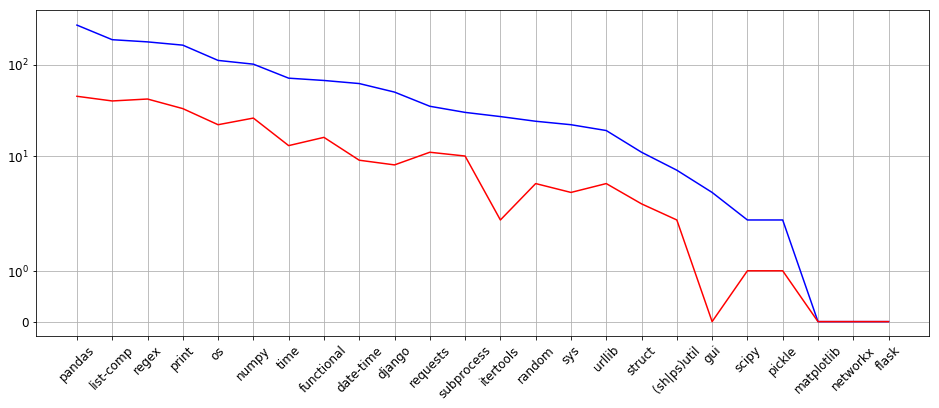

In [70]:
train_xs = get_by_keywords(train_data)
test_xs = get_by_keywords(test_data)

# print("[train]")
# for l, qs in sorted(train_xs.items(), key=lambda k : len(k[1]), reverse=True):
#     print(f"{l} -> {len(qs)}({round(100.0 * len(qs)/len(train_data), 3)}%)")
# print()

# print("[test]")
# for l, qs in sorted(test_xs.items(), key=lambda k : len(k[1]), reverse=True):
#     print(f"{l} -> {len(qs)}({round(100.0 * len(qs)/len(test_data), 3)}%)")
# print()

s = sorted(train_xs.items(), key=lambda k : len(k[1]), reverse=True)
labels = [x[0] for x in s]

plt.figure(figsize=(16,6))
plt.xticks(range(len(s)), labels, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('symlog')
plt.plot(range(len(s)), [len(x[1]) for x in s], 'b-')
plt.plot(range(len(s)), [len(test_xs[k]) for k in labels], 'r-')
plt.grid()
plt.show()

# for l, qs in xs.items():
#     print(colored(l, "green"))
#     for q in qs[:2]:
#         pprint(q)
#         print()

In [6]:
# for i, uid in enumerate(uids, start=1):
#     print(f"{i}:")
#     for q in get_by_qid(data, uid):
#         print("> ", q["rewritten_intent"])
#         print("> ", q["snippet"])
#         print()
#     print("-"*32)

In [7]:
QUOTED_TOKEN_RE = re.compile(r"(?P<quote>''|[`'\"])(?P<string>.*?)(?P=quote)")


def infer_slot_type(quote, value):
    if quote == '`' and value.isidentifier():
        return 'var'
    return 'str'


def canonicalize_intent(intent):
    # handle the following special case: quote is `''`
    marked_token_matches = QUOTED_TOKEN_RE.findall(intent)

    slot_map = dict()
    var_id = 0
    str_id = 0
    for match in marked_token_matches:
        quote = match[0]
        value = match[1]
        quoted_value = quote + value + quote

        # try:
        #     # if it's a number, then keep it and leave it to the copy mechanism
        #     float(value)
        #     intent = intent.replace(quoted_value, value)
        #     continue
        # except:
        #     pass

        slot_type = infer_slot_type(quote, value)

        if slot_type == 'var':
            slot_name = 'var_%d' % var_id
            var_id += 1
            slot_type = 'var'
        else:
            slot_name = 'str_%d' % str_id
            str_id += 1
            slot_type = 'str'

        # slot_id = len(slot_map)
        # slot_name = 'slot_%d' % slot_id
        # # make sure slot_name is also unicode
        # slot_name = unicode(slot_name)

        intent = intent.replace(quoted_value, slot_name)
        slot_map[slot_name] = {'value': value.strip().encode().decode('unicode_escape', 'ignore'),
                               'quote': quote,
                               'type' : slot_type}

    return intent, slot_map

In [8]:
x = random.sample(train_data, 1)[0]

i = x['rewritten_intent'] if x['rewritten_intent'] is not None else x['intent']
print(i)
print("---")

i, s = canonicalize_intent(i)

print(i)
print("---")

pprint(s)

control the keyboard and mouse with dogtail in linux
---
control the keyboard and mouse with dogtail in linux
---
{}
